# Gammapy Table Model
Here is an example for building and using a gammapy table model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from cascapy.cascade import *
from cascapy.constants import *
from cascapy.tablemodel import *
from cascapy.gammapy import *

### Set the table to be used

In [2]:
file = './data/table.h5'

## Build a simple table model and visualize the results with a widget

In [3]:
# Build model with a slight smoothing and a frozen parameter
models = CascadeTemporalSpectralModel(file,smooth_dex=0.1)

# Display models info
print(models)

CascadeTemporalSpectralModel

Component 0: SkyModel

  Name                      : test00
  Datasets names            : None
  Spectral model type       : ScaledTemplateNDSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    scale@fLJUwtAj                :      1.000   +/-    0.00             
    alpha@q1fQ0dLN                :      1.500   +/-    0.00             
    gamma@OWRtN9VH                :      2.100   +/-    0.00             

Component 1: SkyModel

  Name                      : test01
  Datasets names            : None
  Spectral model type       : ScaledTemplateNDSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    scale@fLJUwtAj                :      1.000   +/-    0.00             
    alpha@q1fQ0dLN                :      1.500   +/-    0.00             
    gamma@OWRtN9VH                :      2.100   +/-    0.00             

Component 2: SkyModel

  Name                      : test02
  

In [4]:
# Print the flux in the first time bin
models[0].spectral_model(1*TeV)

<Quantity [1.25245589e-10] 1 / (erg s cm2)>

<IPython.core.display.Javascript object>


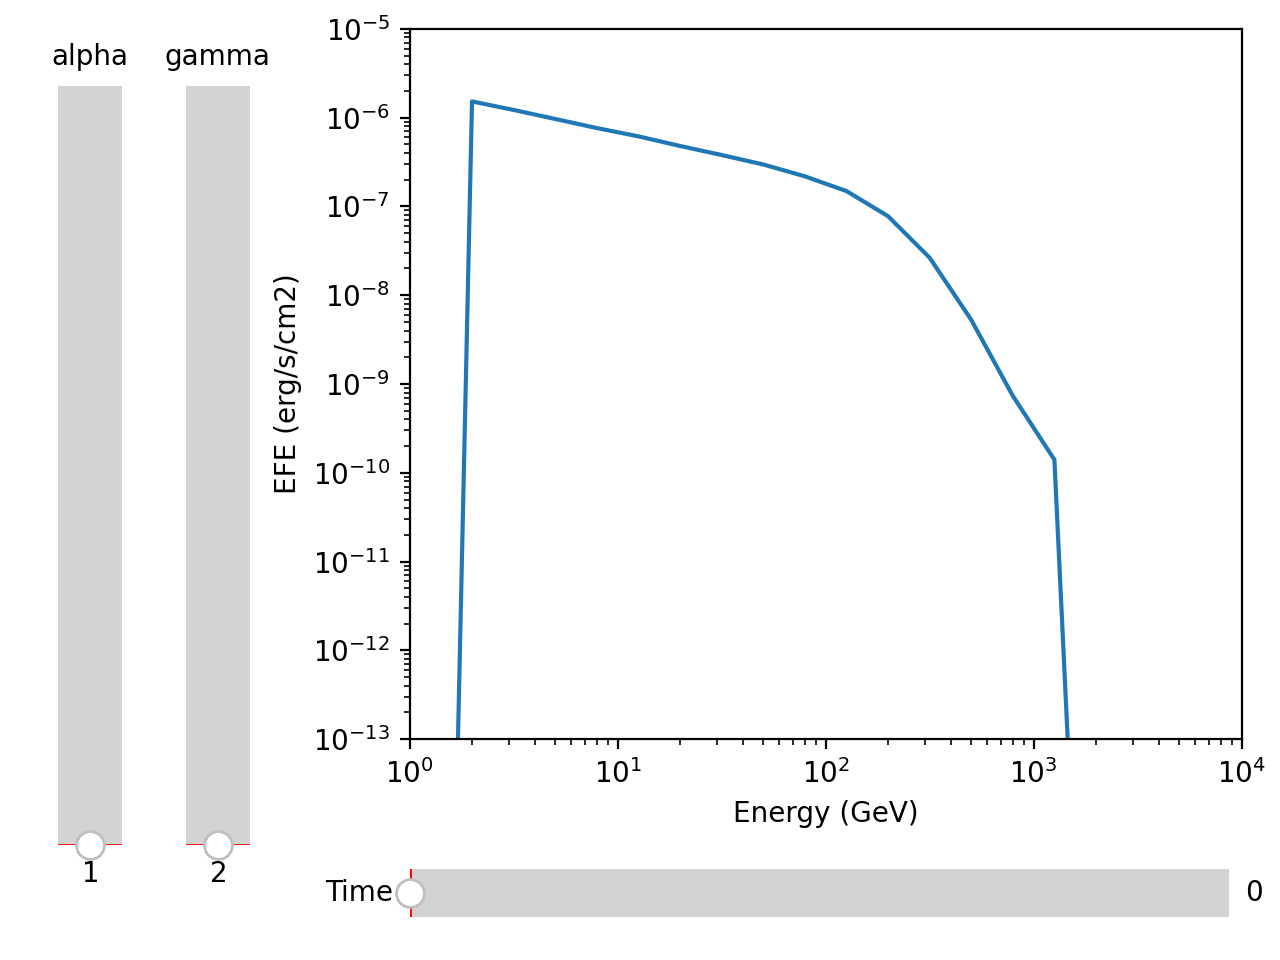

In [5]:
# Visualize table
%matplotlib notebook
models.spectra()

<IPython.core.display.Javascript object>


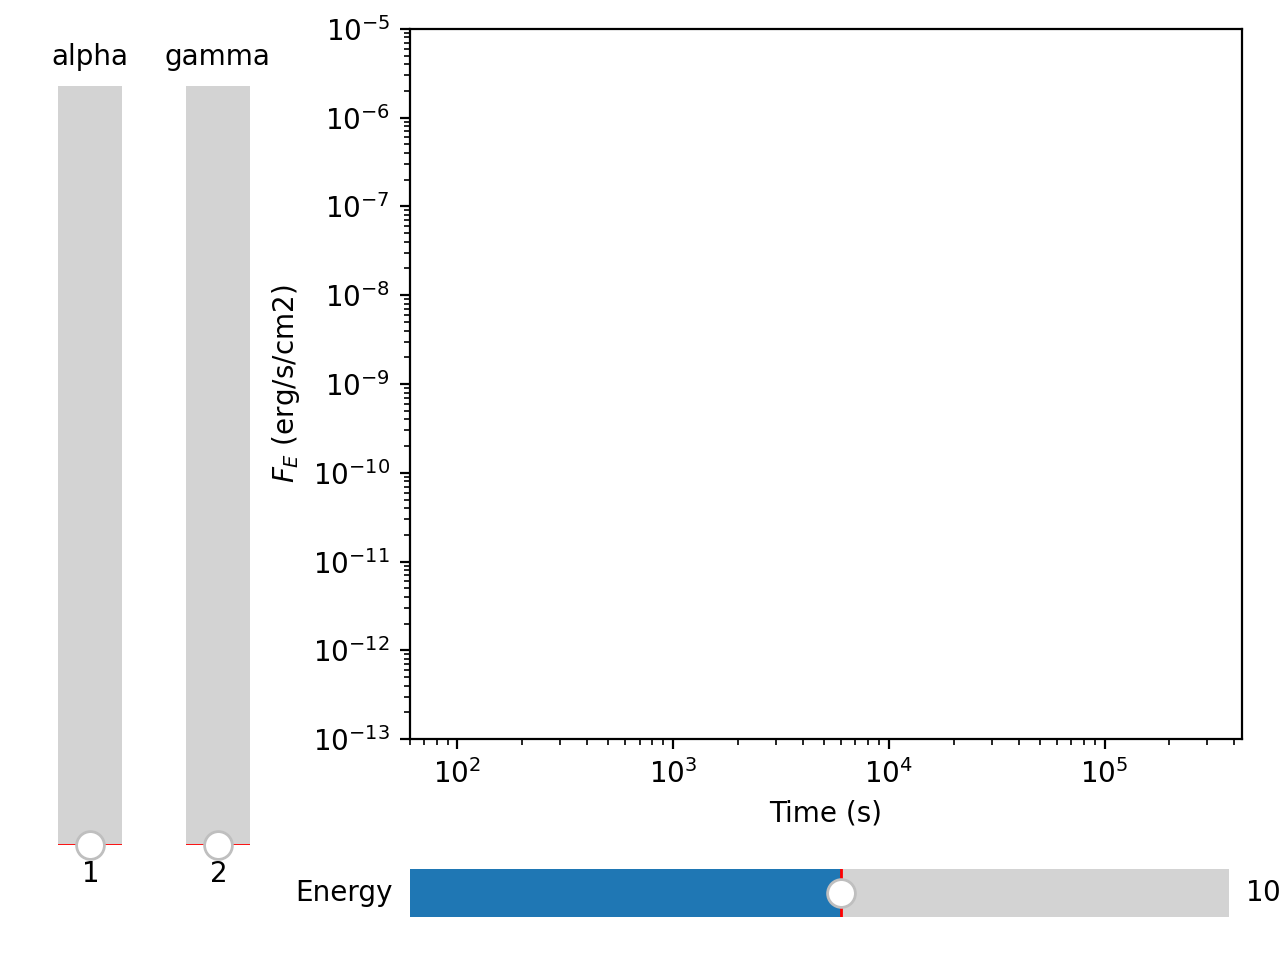

In [6]:
models.lightcurves()

In [7]:
%matplotlib inline

## Build a table model and plot interpolated spectra
- Build the model...

Here, no parameter is frozen. A smoothing of width 0.2dex is applied to the original table data

In [4]:
models = CascadeTemporalSpectralModel(file,smooth_dex=0.1)

- Setup parameter values

In [5]:
models[0].parameters["gamma"].value = 1.3
models[0].parameters["alpha"].value = 1.2
# Check that the parameters have been updated
for name,value in zip(models[0].parameters.names,models[0].parameters.value):
    print(f"{name:8}: {value}")

scale   : 1.0
alpha   : 1.2
gamma   : 1.3


- Plot spectra for a few different spectral indices

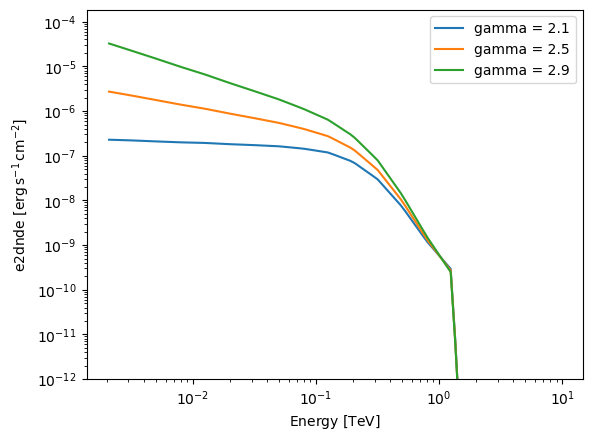

In [6]:
# select one time bin
it = 1

# Plot the spectra for different spectral indices
for gamma in [2.1,2.5,2.9]:
    models[0].parameters["gamma"].value = gamma
    models[it].spectral_model.plot((2.e0*u.GeV,10*u.TeV),sed_type='e2dnde',label=f"gamma = {gamma}")

# setup plot options
plt.ylim(1.e-12,)
plt.legend()
plt.show()

## Compare the gammapy model to the original table and to MC results
- Define the parameters used for comparison

In [10]:
pars = {'gamma':1.88,'scale':1.0}
frozen = {'alpha':1.34}
allpars = frozen|pars

- Define model and update parameters and check

In [12]:
# Build model
models = CascadeTemporalSpectralModel(file,smooth_dex=0.1,frozen=frozen)

# update parameters
for key,val in pars.items():
    models[0].parameters[key].value = val

# Display the updated parameter values
for name,value in zip(models[0].parameters.names,models[0].parameters.value):
    print(f"{name:8}: {value}")

scale   : 1.0
gamma   : 1.88


- Select a time bin of interest

In [13]:
it = 4
model = models[it]

- Get the closest spectrum in original table

In [14]:
# read table
tbl = TableModel(file=file,mode='r')

# get indices of nearest tabulated values
ind = []
for name,par in tbl.vparams.items() :
    if name in allpars.keys():
        ind += [np.argmin(np.abs(par.values-allpars[name]))]
        print(name,allpars[name],par.values[ind[-1]])
        
# compute corresponding tabulated flux
ea = (tbl.ebins[:,0]*tbl.ebins[:,1])**0.5
efe = ea**2 * np.sum(tbl.data[:,*ind,it,:],axis=0)

gamma 1.88 1.8428571
alpha 1.34 1.3333334


- Get Monte Carlo results

In [15]:
# get source model from table
Smodel = tbl.smodel
Smodel.update(allpars)
Smodel.info()

# get values of the closest magentic value for which a MC file exists, and get file name
file =  './data/' + parse_filename({'logB':tbl.fparams['logB'],'lambdaB':6,'z':Smodel.params['z']})

# Read file
emin, emax = tbl.ebins[0,0], tbl.ebins[-1,-1]
tmin, tmax = tbl.tbins[it,0], tbl.tbins[it,1]
evc = EventCatalog(filename=file,gen=[0,1,2,3],emin=emin,emax=emax,tmax=tmax,thdmax=1*degree,chatter=0)

# Apply binning and model
nbin = 60
eb = np.logspace(np.log10(emin),np.log10(emax),nbin+1)
e = (eb[1:]*eb[:-1])**.5
tbins = np.array([tmin,tmax])
bd = BinnedData(evc,ebins=eb,tbins=tbins,gbins=[0,1,2,3],smodel=Smodel)

# Add contribution from primaries and secondaries
y = np.sum(bd.data[:,:],axis=0)

ENERGY SPECTRUM:
   Spectral model:
   Etype           =       PL
   z               =   0.4245
   gamma           =     1.88
   emin            = 1.602176634e-05
   emax            = 16.02176634
   epiv            = 1.6021766339999999
TIME EVOLUTION:
   Time model:
   Ttype           =       PL
   alpha           =     1.34
   tmin            =        6
   tmax            =    1e+20
ANGULAR DISTRIBUTION:
   Angular model:
   Atype           =      Iso
   th_obs          =      0.0
POINT SOURCE NORMALIZATION:
   norm  = 3.07e-05

Binning Data
This might take a minute or so...
Done


- Plot all results

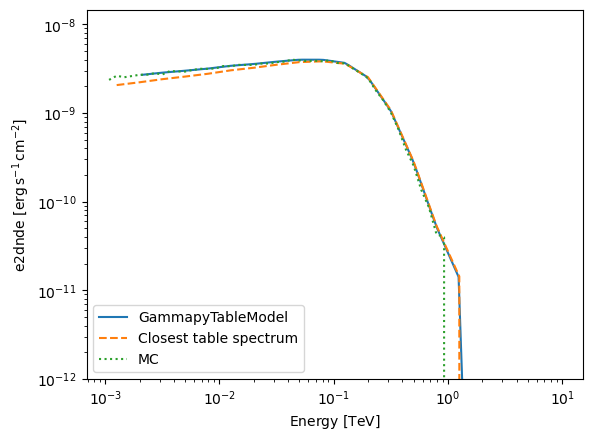

In [16]:
# Plot gammapy interpolated spectrum
model.spectral_model.plot((2.e0*u.GeV,10*u.TeV),sed_type='e2dnde',label=f"GammapyTableModel")

# Plot closest spectrum in the table
plt.plot(ea/TeV,efe,ls='--',label='Closest table spectrum')


# Plot results MC simulation with the closest logB
plt.plot(e/TeV,e**2*y,ls=':',label=f"MC")

# setup plot options
plt.ylim(1.e-12,)
plt.legend()
plt.show()